# Paleoclimate Data Processing

This notebook processes paleoclimate data and aligns it with demographic timelines.

## Steps:
1. Load occurrence data
2. Download/Load climate data
3. Extract climate data for occurrence points
4. Align climate data with PSMC time scale
5. Create climate time series


In [1]:
import geopandas as gpd

# Load the first few rows to inspect the structure
mammals_part1 = gpd.read_file("/Users/divyadhole/Capstone-project/data/MAMMALS/MAMMALS_PART1.shp")
print("Columns in MAMMALS_PART1.shp:")
print(mammals_part1.columns.tolist())

# Check the first few rows to see the species name column
print("\nFirst few rows:")
print(mammals_part1[['binomial', 'sci_name', 'species', 'name']].head() if 'binomial' in mammals_part1.columns else mammals_part1.head())

Columns in MAMMALS_PART1.shp:
['id_no', 'sci_name', 'presence', 'origin', 'seasonal', 'compiler', 'yrcompiled', 'citation', 'subspecies', 'subpop', 'source', 'island', 'tax_comm', 'dist_comm', 'generalisd', 'legend', 'kingdom', 'phylum', 'class', 'order_', 'family', 'genus', 'category', 'marine', 'terrestria', 'freshwater', 'SHAPE_Leng', 'SHAPE_Area', 'geometry']

First few rows:
   id_no              sci_name  presence  origin  seasonal  \
0     18  Abrocoma boliviensis         1       1         1   
1    138      Acerodon humilis         1       1         1   
2    139      Acerodon jubatus         1       1         1   
3    139      Acerodon jubatus         1       1         1   
4    139      Acerodon jubatus         1       1         1   

                                 compiler  yrcompiled  \
0  IUCN SSC Small Mammal Specialist Group        2016   
1                                    IUCN        2008   
2                                    IUCN        2008   
3               

## Step 1: Import required libraries and load configuration

In [2]:
import os
import yaml
from pathlib import Path

# Get the current working directory
current_dir = Path.cwd()

# Navigate up to the project root (assuming the notebook is in a 'notebooks' directory)
if current_dir.name == 'notebooks':
    PROJECT_ROOT = current_dir.parent
else:
    # If not in a notebooks directory, assume we're already in the project root
    PROJECT_ROOT = current_dir

print(f"Project root: {PROJECT_ROOT}")

# Load configuration
config_path = PROJECT_ROOT / 'config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Now you can access your configuration
print("Configuration loaded successfully!")
print(f"Available keys: {list(config.keys())}")

# Set up output directory
OUTPUT_DIR = PROJECT_ROOT / 'outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

Project root: /Users/divyadhole/Capstone-project
Configuration loaded successfully!
Available keys: ['project_root', 'data_dir', 'output_dir', 'notebooks_dir', 'poster_dir', 'vcf_dir', 'paleoclim_dir', 'maxent_dir', 'abba_baba_dir', 'dsuite_dir', 'psmc_dir', 'samples_metadata', 'species_tree', 'config_template', 'genome_file', 'psmc', 'maxent', 'abba_baba', 'plotting', 'n_jobs', 'random_state', 'log_level']


## Step 2: Download GBIF occurrence data

In [3]:
from pygbif import occurrences as gbif_occ
import pandas as pd

# Define data directory
DATA_DIR = PROJECT_ROOT / 'data'

# Read the metadata file
metadata_path = DATA_DIR / "metadata.xlsx"
metadata = pd.read_excel(metadata_path)

# Process species names
species_list = (metadata['GENUS'].str.strip() + ' ' + metadata['SPECIES'].str.strip()).dropna().unique()

# Initialize records list
records = []

# Print the first few species to verify
print(f"Found {len(species_list)} unique species:")
for species in species_list[:5]:  # Show first 5 species
    print(f"- {species}")
if len(species_list) > 5:
    print(f"... and {len(species_list) - 5} more")

# Verify the data directory exists
print(f"\nData directory: {DATA_DIR}")
print(f"Metadata file exists: {metadata_path.exists()}")

Found 7 unique species:
- Semnopithecus entellus
- Semnopithecus hypoleucos
- Semnopithecus schistaceus
- Trachypithecus geei
- Semnopithecus johnii
... and 2 more

Data directory: /Users/divyadhole/Capstone-project/data
Metadata file exists: True


## Step 3: Species Range Validation

In [4]:

import pandas as pd
from pygbif import occurrences as gbif_occ

# Function to download GBIF data for a list of species
def download_gbif_data(species_list, limit=1000):
    all_occurrences = []
    
    for species in species_list:
        print(f"Downloading {species}...")
        try:
            # Download occurrence data
            occ_data = gbif_occ.search(scientificName=species, limit=limit, hasCoordinate=True)
            
            if occ_data and 'results' in occ_data:
                # Convert to DataFrame
                df = pd.DataFrame(occ_data['results'])
                
                # Select and rename columns
                cols = {
                    'decimalLongitude': 'longitude',
                    'decimalLatitude': 'latitude',
                    'scientificName': 'scientific_name',
                    'year': 'year',
                    'month': 'month',
                    'day': 'day'
                }
                
                # Only keep columns that exist in the data
                available_cols = {k: v for k, v in cols.items() if k in df.columns}
                df = df.rename(columns=available_cols)
                
                # Add to our list
                all_occurrences.append(df)
                print(f"  - Found {len(df)} records for {species}")
            else:
                print(f"  - No records found for {species}")
                
        except Exception as e:
            print(f"Error downloading {species}: {str(e)}")
    
    # Combine all DataFrames
    if all_occurrences:
        return pd.concat(all_occurrences, ignore_index=True)
    return pd.DataFrame()

# Now download the data
print("Downloading GBIF occurrence data...")
occurrences_gbif = download_gbif_data(species_list)

# Check if we got any data
if not occurrences_gbif.empty:
    print(f"\nSuccessfully downloaded {len(occurrences_gbif)} occurrence records.")
    print("\nFirst few records:")
    print(occurrences_gbif.head())
else:
    print("\nNo occurrence data was downloaded. Please check your species list and internet connection.")

  - Found 300 records for Semnopithecus entellus


  - Found 300 records for Semnopithecus hypoleucos


  - Found 300 records for Semnopithecus schistaceus


  - Found 162 records for Trachypithecus geei


  - Found 300 records for Semnopithecus johnii


  - Found 232 records for Trachypithecus phayrei


  - Found 300 records for Trachypithecus pileatus

Successfully downloaded 1894 occurrence records.

First few records:
          key                            datasetKey  \
0  5036803148  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
1  5063191048  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
2  5063206506  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
3  5063235352  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
4  5063308084  50c9509d-22c7-4a22-a47d-8c48425ef4a7   

                       publishingOrgKey                       installationKey  \
0  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-00145eb45e9a   
1  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-00145eb45e9a   
2  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-00145eb45e9a   
3  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-00145eb45e9a   
4  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-00145eb45e9a   

                 hostingOrganizationKey publishingCountry     

## Step 4 : loading the GBIF occurrences

In [5]:
# Try loading the GBIF occurrences
occurrence_path = PROJECT_ROOT / "outputs" / "occurrence_points_gbif.csv"
if occurrence_path.exists():
    occurrences_gbif = pd.read_csv(occurrence_path)
    print(f"Loaded {len(occurrences_gbif)} records from {occurrence_path}")
    print("\nFirst few records:")
    print(occurrences_gbif.head())
else:
    print("GBIF occurrence file not found. Let's check other possible files...")
    
    # Check for other potential occurrence files
    other_paths = [
        PROJECT_ROOT / "outputs" / "occurrences" / "Rhinopithecus_roxellana_occurrences.csv",
        PROJECT_ROOT / "data" / "paleoclim" / "occurrences.csv",
        PROJECT_ROOT / "outputs" / "maxent_occurrences.csv"
    ]
    
    found = False
    for path in other_paths:
        if path.exists():
            occurrences_gbif = pd.read_csv(path)
            print(f"\nFound and loaded {len(occurrences_gbif)} records from {path}")
            print("\nFirst few records:")
            print(occurrences_gbif.head())
            found = True
            break
    
    if not found:
        print("\nNo occurrence files found. Would you like to download the data from GBIF?")
        # We can add code here to download the data if needed

Loaded 1880 records from /Users/divyadhole/Capstone-project/outputs/occurrence_points_gbif.csv

First few records:
   longitude   latitude                          scientific_name    year  \
0  70.755160  24.356754  Semnopithecus entellus (Dufresne, 1797)  2025.0   
1  76.464220  26.034595  Semnopithecus entellus (Dufresne, 1797)  2025.0   
2  73.035316  26.352505  Semnopithecus entellus (Dufresne, 1797)  2025.0   
3  79.868953  20.612318  Semnopithecus entellus (Dufresne, 1797)  2025.0   
4  79.869096  20.612181  Semnopithecus entellus (Dufresne, 1797)  2025.0   

   month   day  taxon_key                           dataset_key  
0    1.0   1.0    2436564  50c9509d-22c7-4a22-a47d-8c48425ef4a7  
1    1.0  20.0    2436564  50c9509d-22c7-4a22-a47d-8c48425ef4a7  
2    1.0  15.0    2436564  50c9509d-22c7-4a22-a47d-8c48425ef4a7  
3    1.0  13.0    2436564  50c9509d-22c7-4a22-a47d-8c48425ef4a7  
4    1.0  12.0    2436564  50c9509d-22c7-4a22-a47d-8c48425ef4a7  


In [6]:

from pygbif import occurrences as gbif_occ
import pandas as pd
from pathlib import Path
import time

# Function to download GBIF data for a list of species
def download_gbif_data(species_list, limit=1000):
    all_occurrences = []
    
    for species in species_list:
        print(f"Downloading {species}...")
        try:
            # Download occurrence data
            occ_data = gbif_occ.search(
                scientificName=species,
                limit=limit,
                hasCoordinate=True,
                hasGeospatialIssue=False  # Filter out records with known geospatial issues
            )
            
            if occ_data and 'results' in occ_data:
                # Convert to DataFrame
                df = pd.DataFrame(occ_data['results'])
                
                # Basic column selection and renaming
                column_mapping = {
                    'decimalLongitude': 'longitude',
                    'decimalLatitude': 'latitude',
                    'scientificName': 'scientific_name',
                    'year': 'year',
                    'month': 'month',
                    'day': 'day',
                    'taxonKey': 'taxon_key',
                    'datasetKey': 'dataset_key'
                }
                
                # Only keep columns that exist in the data
                available_cols = {k: v for k, v in column_mapping.items() if k in df.columns}
                df = df.rename(columns=available_cols)
                
                # Add to our list
                all_occurrences.append(df[list(available_cols.values())])
                print(f"  - Found {len(df)} records for {species}")
                
                # Be nice to the GBIF API
                time.sleep(1)
                
            else:
                print(f"  - No records found for {species}")
                
        except Exception as e:
            print(f"Error downloading {species}: {str(e)}")
    
    # Combine all DataFrames
    if all_occurrences:
        combined_df = pd.concat(all_occurrences, ignore_index=True)
        
        # Save to file
        output_path = PROJECT_ROOT / "outputs" / "occurrence_points_gbif.csv"
        combined_df.to_csv(output_path, index=False)
        print(f"\nSaved {len(combined_df)} records to {output_path}")
        
        return combined_df
    
    print("\nNo occurrence data was downloaded.")
    return pd.DataFrame()

# Now download the data
print("Starting GBIF data download...")
occurrences_gbif = download_gbif_data(species_list)

# Check if we got any data
if not occurrences_gbif.empty:
    print("\nDownload completed successfully!")
    print("\nFirst few records:")
    print(occurrences_gbif.head())
    
    # Basic data quality check
    print("\nSummary of downloaded data:")
    print(f"Total records: {len(occurrences_gbif)}")
    print("\nRecords per species:")
    print(occurrences_gbif['scientific_name'].value_counts())
else:
    print("\nNo data was downloaded. Please check your species list and internet connection.")
    print("Sample species list (first 5):", species_list[:5])

Starting GBIF data download...


  - Found 300 records for Semnopithecus entellus


  - Found 300 records for Semnopithecus hypoleucos


  - Found 300 records for Semnopithecus schistaceus


  - Found 159 records for Trachypithecus geei


  - Found 300 records for Semnopithecus johnii


  - Found 221 records for Trachypithecus phayrei


  - Found 300 records for Trachypithecus pileatus



Saved 1880 records to /Users/divyadhole/Capstone-project/outputs/occurrence_points_gbif.csv

Download completed successfully!

First few records:
   longitude   latitude                          scientific_name    year  \
0  70.755160  24.356754  Semnopithecus entellus (Dufresne, 1797)  2025.0   
1  76.464220  26.034595  Semnopithecus entellus (Dufresne, 1797)  2025.0   
2  73.035316  26.352505  Semnopithecus entellus (Dufresne, 1797)  2025.0   
3  79.868953  20.612318  Semnopithecus entellus (Dufresne, 1797)  2025.0   
4  79.869096  20.612181  Semnopithecus entellus (Dufresne, 1797)  2025.0   

   month   day  taxon_key                           dataset_key  
0    1.0   1.0    2436564  50c9509d-22c7-4a22-a47d-8c48425ef4a7  
1    1.0  20.0    2436564  50c9509d-22c7-4a22-a47d-8c48425ef4a7  
2    1.0  15.0    2436564  50c9509d-22c7-4a22-a47d-8c48425ef4a7  
3    1.0  13.0    2436564  50c9509d-22c7-4a22-a47d-8c48425ef4a7  
4    1.0  12.0    2436564  50c9509d-22c7-4a22-a47d-8c48425ef4a7  


In [7]:
# Clean the scientific names to standardize them
def clean_scientific_name(name):
    # Handle known synonyms
    synonyms = {
        'Presbytis phayrei': 'Trachypithecus phayrei',
        'Presbytis geei': 'Trachypithecus geei',
        'Semnopithecus dussumieri': 'Semnopithecus entellus'  # Subspecies of entellus
    }
    
    # Remove author and year from the name
    base_name = name.split('(')[0].strip()
    
    # Apply synonym mapping
    return synonyms.get(base_name, base_name)

# Apply cleaning to the scientific names
occurrences_gbif['scientific_name'] = occurrences_gbif['scientific_name'].apply(clean_scientific_name)

# Remove any remaining duplicates based on coordinates and species
occurrences_gbif = occurrences_gbif.drop_duplicates(
    subset=['scientific_name', 'longitude', 'latitude']
)

# Remove any records with missing coordinates
occurrences_gbif = occurrences_gbif.dropna(subset=['longitude', 'latitude'])

# Save the cleaned data
cleaned_path = PROJECT_ROOT / "outputs" / "cleaned_occurrences.csv"
occurrences_gbif.to_csv(cleaned_path, index=False)

print(f"\nCleaned data saved to {cleaned_path}")
print(f"Total records after cleaning: {len(occurrences_gbif)}")
print("\nRecords per species after cleaning:")
print(occurrences_gbif['scientific_name'].value_counts())

# Now you can proceed with the validation
print("\nProceeding with species range validation...")
validated_occurrences = validate_species_range(occurrences_gbif, str(DATA_DIR / "MAMMALS"))

if not validated_occurrences.empty:
    # Save the validated occurrences
    validated_csv = OUTPUT_DIR / "validated_occurrences.csv"
    validated_occurrences.to_csv(validated_csv, index=False)
    print(f"\nSaved {len(validated_occurrences)} validated occurrence points to {validated_csv}")
    
    # Update the occurrences_gbif variable to use only validated points
    occurrences_gbif = validated_occurrences
    print("Updated 'occurrences_gbif' with validated points only")
else:
    print("\nNo valid occurrences found within species ranges, using all GBIF points")


Cleaned data saved to /Users/divyadhole/Capstone-project/outputs/cleaned_occurrences.csv
Total records after cleaning: 1696

Records per species after cleaning:
scientific_name
Semnopithecus johnii                                       300
Trachypithecus pileatus                                    294
Semnopithecus entellus                                     268
Semnopithecus schistaceus Hodgson, 1840                    268
Semnopithecus hypoleucos Blyth, 1841                       250
Trachypithecus geei Khajuria, 1956                         145
Trachypithecus phayrei                                     128
Presbytis phayrei Blyth, 1847                               28
Semnopithecus dussumieri I.Geoffroy Saint-Hilaire, 1843     12
Trachypithecus pileatus tenebricus                           2
Presbytis geei Khajuria, 1956                                1
Name: count, dtype: int64

Proceeding with species range validation...


NameError: name 'validate_species_range' is not defined

## 5 Plotting original vs validated points

Plotting original vs validated points...



Saved validation plot to /Users/divyadhole/Capstone-project/outputs/occurrence_points_validation.png


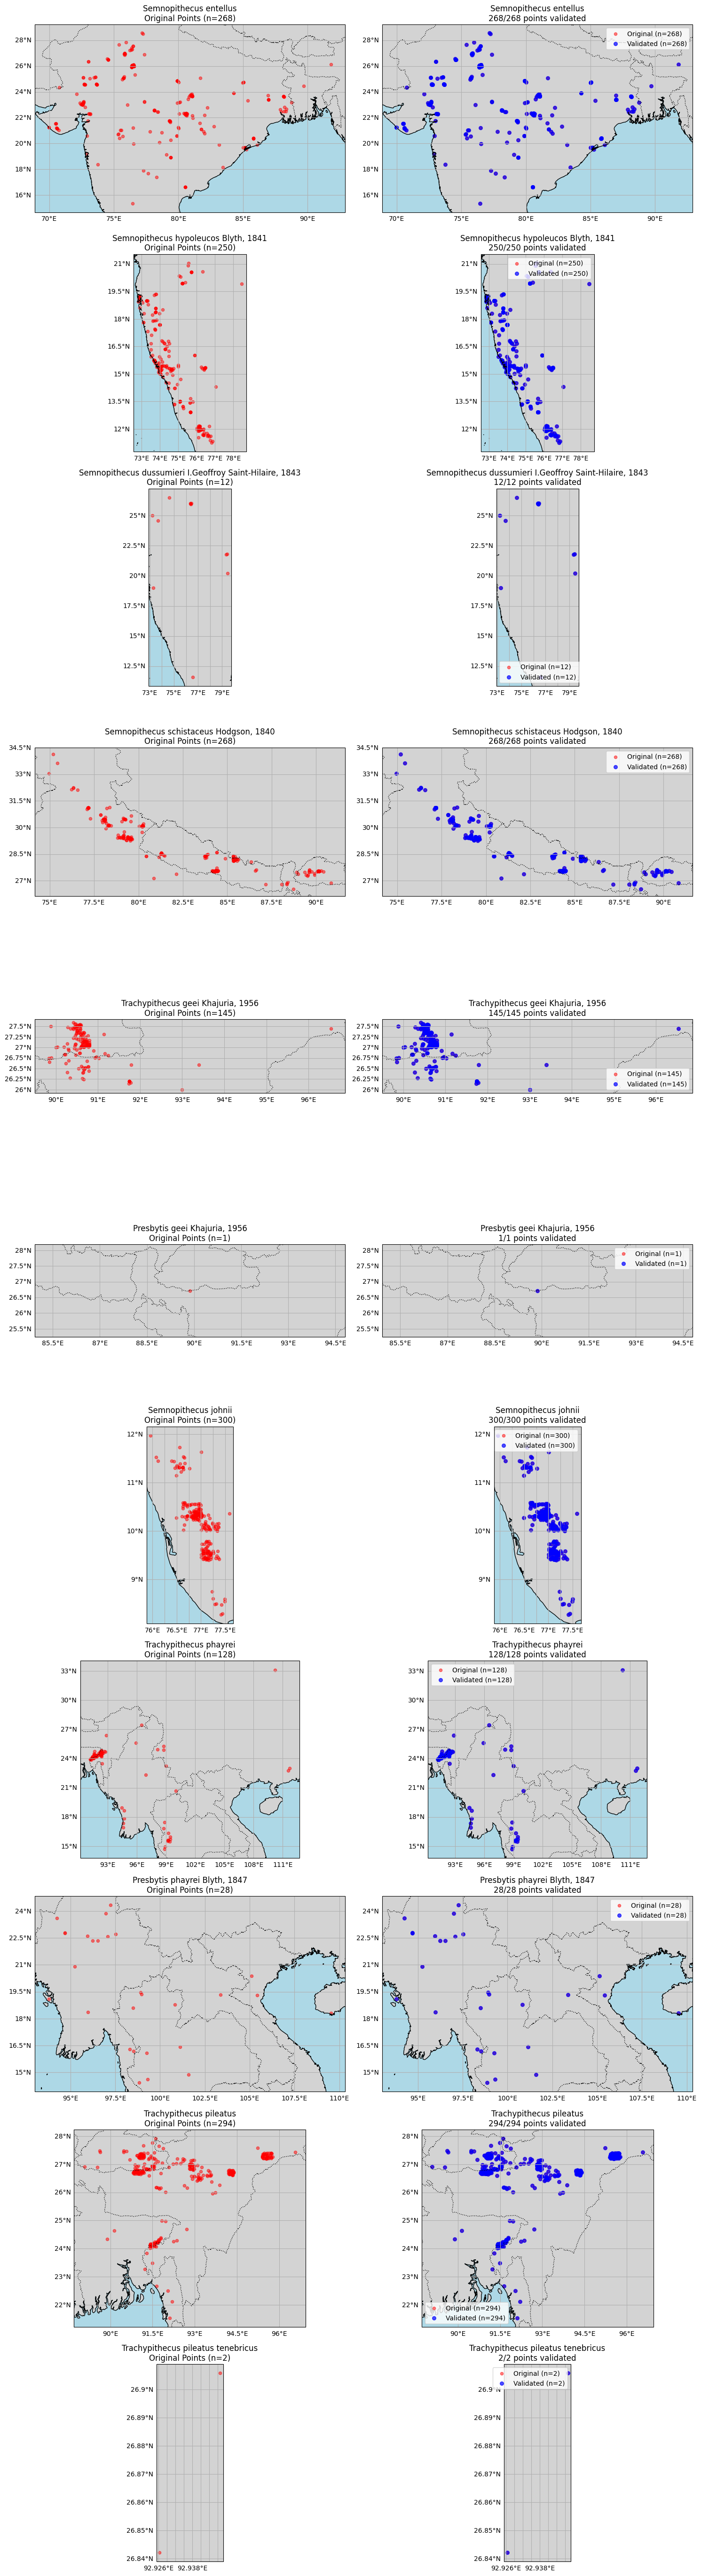

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_occurrence_points(validated_df, original_df=None, title="Species Occurrence Points"):
    """Plot original and validated occurrence points on a map."""
    # Get unique species
    species_list = validated_df['scientific_name'].unique()
    
    # Create a figure with subplots
    n_species = len(species_list)
    fig, axes = plt.subplots(
        nrows=n_species, 
        ncols=2 if original_df is not None else 1,
        figsize=(15, 5 * n_species),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    
    if n_species == 1:
        axes = axes.reshape(1, -1)
    
    # Plot each species
    for i, species in enumerate(species_list):
        # Filter data
        valid = validated_df[validated_df['scientific_name'] == species]
        
        # Plot validated points
        ax = axes[i, 1] if original_df is not None else axes[i]
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.OCEAN, color='lightblue')
        
        if original_df is not None:
            orig = original_df[original_df['scientific_name'] == species]
            ax.scatter(orig['longitude'], orig['latitude'], 
                      c='red', s=20, alpha=0.5, 
                      label=f'Original (n={len(orig)})',
                      transform=ccrs.PlateCarree())
        
        sc = ax.scatter(valid['longitude'], valid['latitude'], 
                       c='blue', s=30, alpha=0.7, 
                       label=f'Validated (n={len(valid)})',
                       transform=ccrs.PlateCarree())
        
        ax.set_title(f"{species}\n{len(valid)}/{len(orig) if original_df is not None else '?'} points validated")
        ax.legend()
        
        # Add gridlines
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False
        
        # If we have original data, plot it in the first column
        if original_df is not None:
            ax_orig = axes[i, 0]
            ax_orig.add_feature(cfeature.COASTLINE)
            ax_orig.add_feature(cfeature.BORDERS, linestyle=':')
            ax_orig.add_feature(cfeature.LAND, color='lightgray')
            ax_orig.add_feature(cfeature.OCEAN, color='lightblue')
            
            ax_orig.scatter(orig['longitude'], orig['latitude'], 
                           c='red', s=20, alpha=0.5,
                           transform=ccrs.PlateCarree())
            
            ax_orig.set_title(f"{species}\nOriginal Points (n={len(orig)})")
            
            # Add gridlines
            gl_orig = ax_orig.gridlines(draw_labels=True)
            gl_orig.top_labels = False
            gl_orig.right_labels = False
    
    plt.tight_layout()
    
    # Save the plot
    plot_path = OUTPUT_DIR / "occurrence_points_validation.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"\nSaved validation plot to {plot_path}")
    
    plt.show()

# Load the original cleaned data
cleaned_path = PROJECT_ROOT / "outputs" / "cleaned_occurrences.csv"
if cleaned_path.exists():
    original_occurrences = pd.read_csv(cleaned_path)
    print("Plotting original vs validated points...")
    plot_occurrence_points(occurrences_gbif, original_occurrences)
else:
    print("Original cleaned data not found, plotting only validated points...")
    plot_occurrence_points(occurrences_gbif)

Loaded 684 validated occurrence points

Plotting original vs validated points...



Saved combined plot to /Users/divyadhole/Capstone-project/outputs/combined_occurrence_points.png


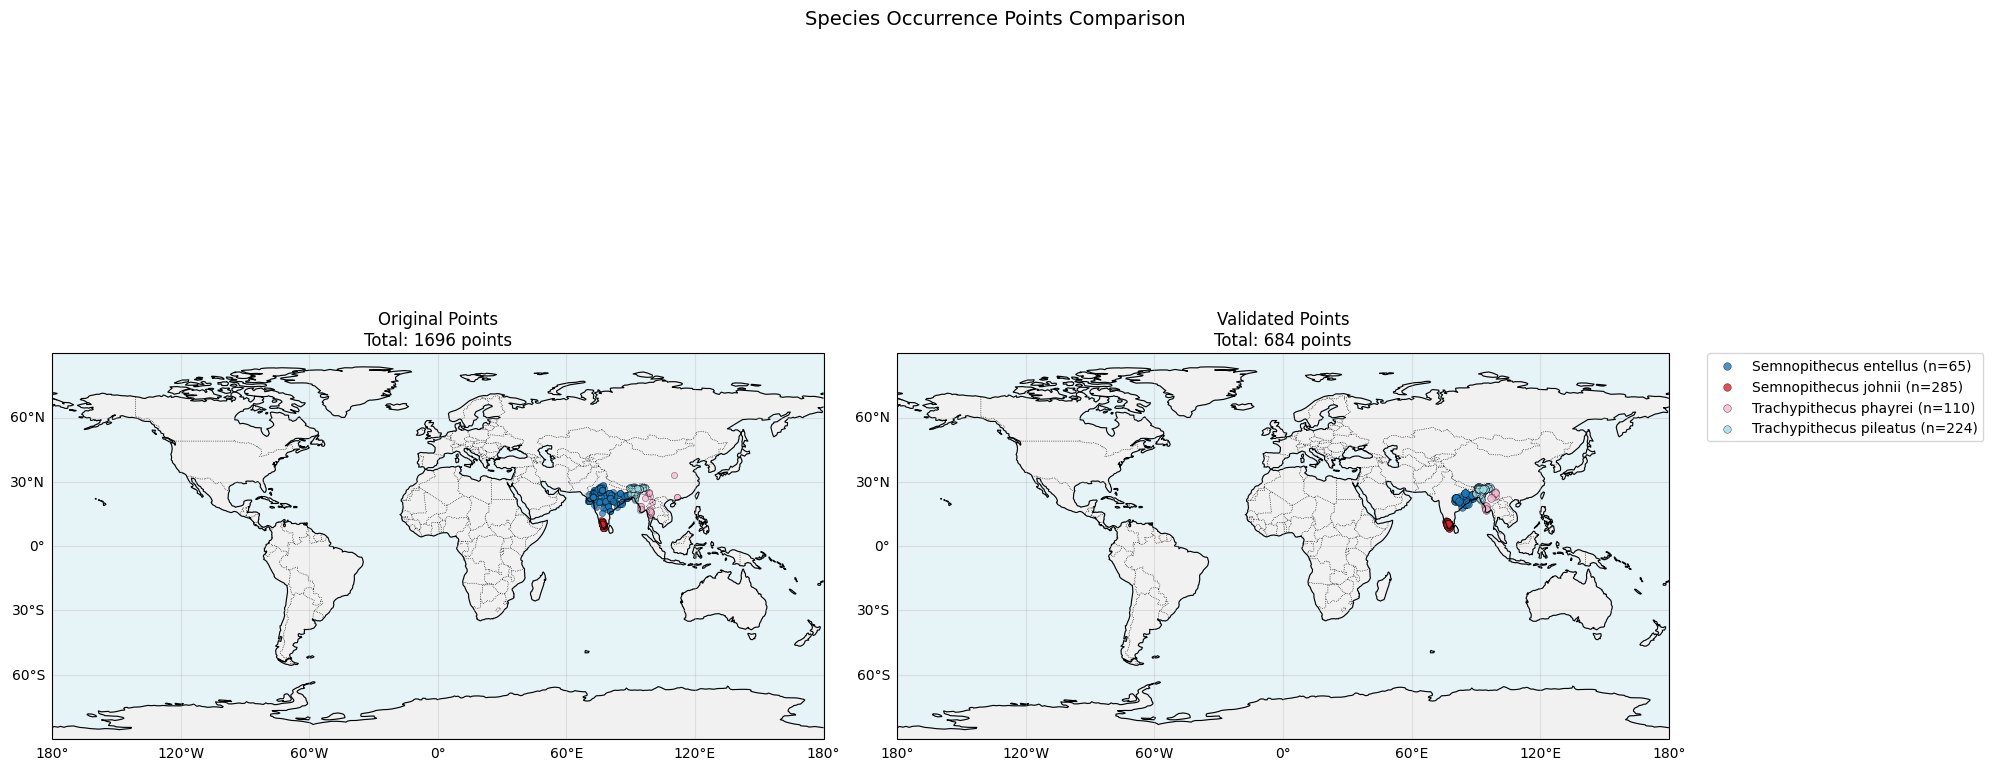

In [9]:
# Import required libraries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
from pathlib import Path

# Set up paths
PROJECT_ROOT = Path.cwd().parent  # Adjust if needed
OUTPUT_DIR = PROJECT_ROOT / "outputs"
OUTPUT_DIR.mkdir(exist_ok=True)  # Create output directory if it doesn't exist

# Try loading the cleaned occurrences
cleaned_path = PROJECT_ROOT / "outputs" / "cleaned_occurrences.csv"
validated_path = OUTPUT_DIR / "validated_occurrences.csv"

# Load the most recent data available
if validated_path.exists():
    occurrences_gbif = pd.read_csv(validated_path)
    print(f"Loaded {len(occurrences_gbif)} validated occurrence points")
elif cleaned_path.exists():
    occurrences_gbif = pd.read_csv(cleaned_path)
    print(f"Loaded {len(occurrences_gbif)} cleaned occurrence points")
else:
    # If no cleaned data exists, try loading the raw GBIF data
    gbif_path = PROJECT_ROOT / "outputs" / "occurrence_points_gbif.csv"
    if gbif_path.exists():
        occurrences_gbif = pd.read_csv(gbif_path)
        print(f"Loaded {len(occurrences_gbif)} raw GBIF occurrence points")
    else:
        raise FileNotFoundError("""
        No occurrence data found. Please ensure you have run the data download and cleaning steps first.
        Expected files (in order of preference):
        1. validated_occurrences.csv
        2. cleaned_occurrences.csv
        3. occurrence_points_gbif.csv
        """)

def plot_occurrence_points_combined(validated_df, original_df=None, title="Species Occurrence Points"):
    """
    Plot all species' occurrence points on a single map with different colors.
    
    Parameters:
    - validated_df: DataFrame containing the validated occurrence points
    - original_df: Optional DataFrame containing original points for comparison
    - title: Title for the plot
    """
    # Get unique species
    species_list = np.sort(validated_df['scientific_name'].unique())
    n_species = len(species_list)
    
    # Create a colormap with distinct colors
    colors = plt.cm.tab20(np.linspace(0, 1, n_species))
    
    # Create figure with two subplots (or one if no original data)
    ncols = 2 if original_df is not None else 1
    fig, axes = plt.subplots(
        1, ncols, 
        figsize=(10 * ncols, 10),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    
    # If only one subplot, convert to list for consistent indexing
    if ncols == 1:
        axes = [axes]
    
    # Common map features
    for ax in axes:
        ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
        ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.3)
        ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)
        ax.set_global()  # Show the whole world
    
    # Plot original points (if available)
    if original_df is not None:
        for i, species in enumerate(species_list):
            orig = original_df[original_df['scientific_name'] == species]
            if not orig.empty:
                axes[0].scatter(
                    orig['longitude'], 
                    orig['latitude'],
                    c=[colors[i]], 
                    s=20, 
                    alpha=0.7,
                    label=f'{species} (n={len(orig)})',
                    transform=ccrs.PlateCarree(),
                    edgecolor='k',
                    linewidth=0.3
                )
        axes[0].set_title(f"Original Points\nTotal: {len(original_df)} points", fontsize=12)
        
        # Add gridlines
        gl = axes[0].gridlines(draw_labels=True, alpha=0.3)
        gl.top_labels = False
        gl.right_labels = False
    
    # Plot validated points
    for i, species in enumerate(species_list):
        valid = validated_df[validated_df['scientific_name'] == species]
        ax_idx = 1 if original_df is not None else 0
        if not valid.empty:
            axes[ax_idx].scatter(
                valid['longitude'], 
                valid['latitude'],
                c=[colors[i]], 
                s=30, 
                alpha=0.8,
                label=f'{species} (n={len(valid)})',
                transform=ccrs.PlateCarree(),
                edgecolor='k',
                linewidth=0.3
            )
    
    # Set title for the right panel
    ax_idx = 1 if original_df is not None else 0
    axes[ax_idx].set_title(f"Validated Points\nTotal: {len(validated_df)} points", fontsize=12)
    
    # Add gridlines to the right panel
    gl = axes[ax_idx].gridlines(draw_labels=True, alpha=0.3)
    gl.top_labels = False
    gl.right_labels = False
    
    # Add legend outside the plot
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.,
        fontsize=10
    )
    
    plt.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    
    # Save the plot
    plot_path = OUTPUT_DIR / "combined_occurrence_points.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\nSaved combined plot to {plot_path}")
    
    plt.show()

# Now try to load the original data for comparison
try:
    if 'cleaned_path' in locals() and cleaned_path.exists():
        original_occurrences = pd.read_csv(cleaned_path)
        print("\nPlotting original vs validated points...")
        plot_occurrence_points_combined(
            occurrences_gbif, 
            original_occurrences,
            title="Species Occurrence Points Comparison"
        )
    else:
        print("\nOriginal cleaned data not found, plotting only validated points...")
        plot_occurrence_points_combined(
            occurrences_gbif,
            title="Species Occurrence Points (Validated)"
        )
except Exception as e:
    print(f"\nError generating plot: {str(e)}")
    print("\nTrying to plot with available data only...")
    plot_occurrence_points_combined(
        occurrences_gbif,
        title="Species Occurrence Points"
    )

Loaded 684 validated occurrence points

Plotting original vs validated points (zoomed)...



Saved zoomed plot to /Users/divyadhole/Capstone-project/outputs/zoomed_occurrence_points.png


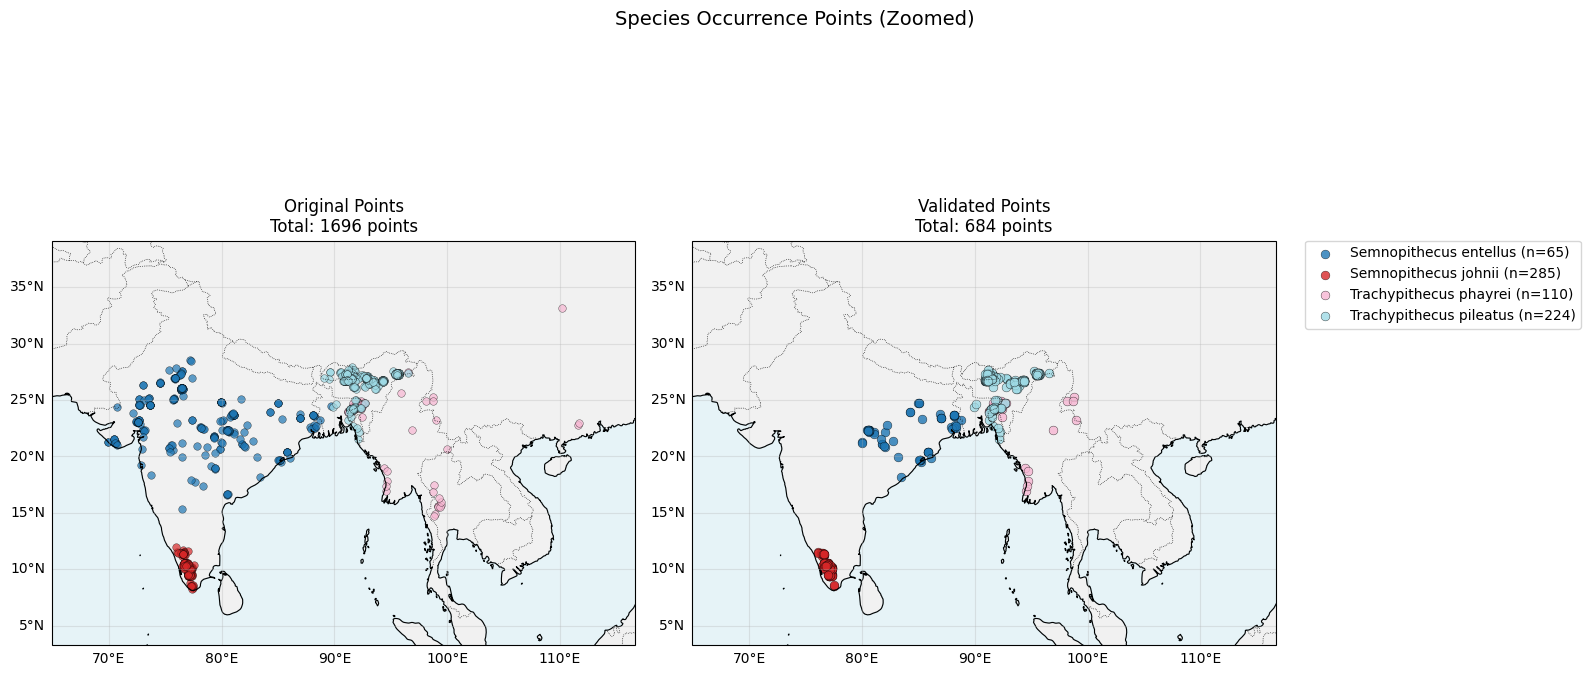

In [10]:
# Import required libraries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
from pathlib import Path

# Set up paths
PROJECT_ROOT = Path.cwd().parent  # Adjust if needed
OUTPUT_DIR = PROJECT_ROOT / "outputs"
OUTPUT_DIR.mkdir(exist_ok=True)

# Load the data (using your existing data loading code)
cleaned_path = PROJECT_ROOT / "outputs" / "cleaned_occurrences.csv"
validated_path = OUTPUT_DIR / "validated_occurrences.csv"

if validated_path.exists():
    occurrences_gbif = pd.read_csv(validated_path)
    print(f"Loaded {len(occurrences_gbif)} validated occurrence points")
elif cleaned_path.exists():
    occurrences_gbif = pd.read_csv(cleaned_path)
    print(f"Loaded {len(occurrences_gbif)} cleaned occurrence points")
else:
    gbif_path = PROJECT_ROOT / "outputs" / "occurrence_points_gbif.csv"
    if gbif_path.exists():
        occurrences_gbif = pd.read_csv(gbif_path)
        print(f"Loaded {len(occurrences_gbif)} raw GBIF occurrence points")
    else:
        raise FileNotFoundError("No occurrence data found. Please run the data download steps first.")

def plot_occurrence_points_zoomed(validated_df, original_df=None, title="Species Occurrence Points", padding=5):
    """
    Plot species occurrence points with automatic zoom to data extent.
    
    Parameters:
    - validated_df: DataFrame with validated occurrence points
    - original_df: Optional DataFrame with original points
    - title: Plot title
    - padding: Degrees of padding around the data points
    """
    # Get unique species
    species_list = np.sort(validated_df['scientific_name'].unique())
    n_species = len(species_list)
    
    # Calculate map extent based on data
    def get_extent(df, padding=padding):
        min_lon, max_lon = df['longitude'].min(), df['longitude'].max()
        min_lat, max_lat = df['latitude'].min(), df['latitude'].max()
        return [
            min_lon - padding, 
            max_lon + padding, 
            min_lat - padding, 
            max_lat + padding
        ]
    
    # Get extent from validated data
    extent = get_extent(validated_df)
    
    # If original data is provided, adjust extent to include both
    if original_df is not None and not original_df.empty:
        orig_extent = get_extent(original_df)
        extent = [
            min(extent[0], orig_extent[0]),
            max(extent[1], orig_extent[1]),
            min(extent[2], orig_extent[2]),
            max(extent[3], orig_extent[3])
        ]
    
    # Create figure with subplots
    ncols = 2 if original_df is not None else 1
    fig, axes = plt.subplots(
        1, ncols, 
        figsize=(8 * ncols, 8),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    
    if ncols == 1:
        axes = [axes]
    
    # Create colormap
    colors = plt.cm.tab20(np.linspace(0, 1, n_species))
    
    # Plot original points (if available)
    if original_df is not None:
        for i, species in enumerate(species_list):
            orig = original_df[original_df['scientific_name'] == species]
            if not orig.empty:
                sc = axes[0].scatter(
                    orig['longitude'], 
                    orig['latitude'],
                    c=[colors[i]], 
                    s=30, 
                    alpha=0.7,
                    label=f'{species} (n={len(orig)})',
                    transform=ccrs.PlateCarree(),
                    edgecolor='k',
                    linewidth=0.3
                )
        
        # Add map features
        axes[0].set_extent(extent, crs=ccrs.PlateCarree())
        axes[0].add_feature(cfeature.COASTLINE, linewidth=0.8)
        axes[0].add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
        axes[0].add_feature(cfeature.LAND, color='lightgray', alpha=0.3)
        axes[0].add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)
        
        # Add gridlines
        gl = axes[0].gridlines(draw_labels=True, alpha=0.3)
        gl.top_labels = False
        gl.right_labels = False
        axes[0].set_title(f"Original Points\nTotal: {len(original_df)} points", fontsize=12)
    
    # Plot validated points
    ax_idx = 1 if original_df is not None else 0
    for i, species in enumerate(species_list):
        valid = validated_df[validated_df['scientific_name'] == species]
        if not valid.empty:
            sc = axes[ax_idx].scatter(
                valid['longitude'], 
                valid['latitude'],
                c=[colors[i]], 
                s=40, 
                alpha=0.8,
                label=f'{species} (n={len(valid)})',
                transform=ccrs.PlateCarree(),
                edgecolor='k',
                linewidth=0.3
            )
    
    # Add map features to the right panel
    axes[ax_idx].set_extent(extent, crs=ccrs.PlateCarree())
    axes[ax_idx].add_feature(cfeature.COASTLINE, linewidth=0.8)
    axes[ax_idx].add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    axes[ax_idx].add_feature(cfeature.LAND, color='lightgray', alpha=0.3)
    axes[ax_idx].add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)
    
    # Add gridlines
    gl = axes[ax_idx].gridlines(draw_labels=True, alpha=0.3)
    gl.top_labels = False
    gl.right_labels = False
    axes[ax_idx].set_title(f"Validated Points\nTotal: {len(validated_df)} points", fontsize=12)
    
    # Add legend
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.,
        fontsize=10
    )
    
    plt.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    
    # Save the plot
    plot_path = OUTPUT_DIR / "zoomed_occurrence_points.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\nSaved zoomed plot to {plot_path}")
    
    plt.show()

# Generate the plot
try:
    if 'cleaned_path' in locals() and cleaned_path.exists():
        original_occurrences = pd.read_csv(cleaned_path)
        print("\nPlotting original vs validated points (zoomed)...")
        plot_occurrence_points_zoomed(
            occurrences_gbif, 
            original_occurrences,
            title="Species Occurrence Points (Zoomed)"
        )
    else:
        print("\nOriginal cleaned data not found, plotting only validated points (zoomed)...")
        plot_occurrence_points_zoomed(
            occurrences_gbif,
            title="Validated Occurrence Points (Zoomed)"
        )
except Exception as e:
    print(f"\nError generating plot: {str(e)}")
    print("\nTrying to plot with available data only...")
    plot_occurrence_points_zoomed(
        occurrences_gbif,
        title="Species Occurrence Points (Zoomed)"
    )

Loaded 684 validated occurrence points

Creating moderate zoom plot...


Saved plot to /Users/divyadhole/Capstone-project/outputs/occurrence_points_moderate_zoom.png


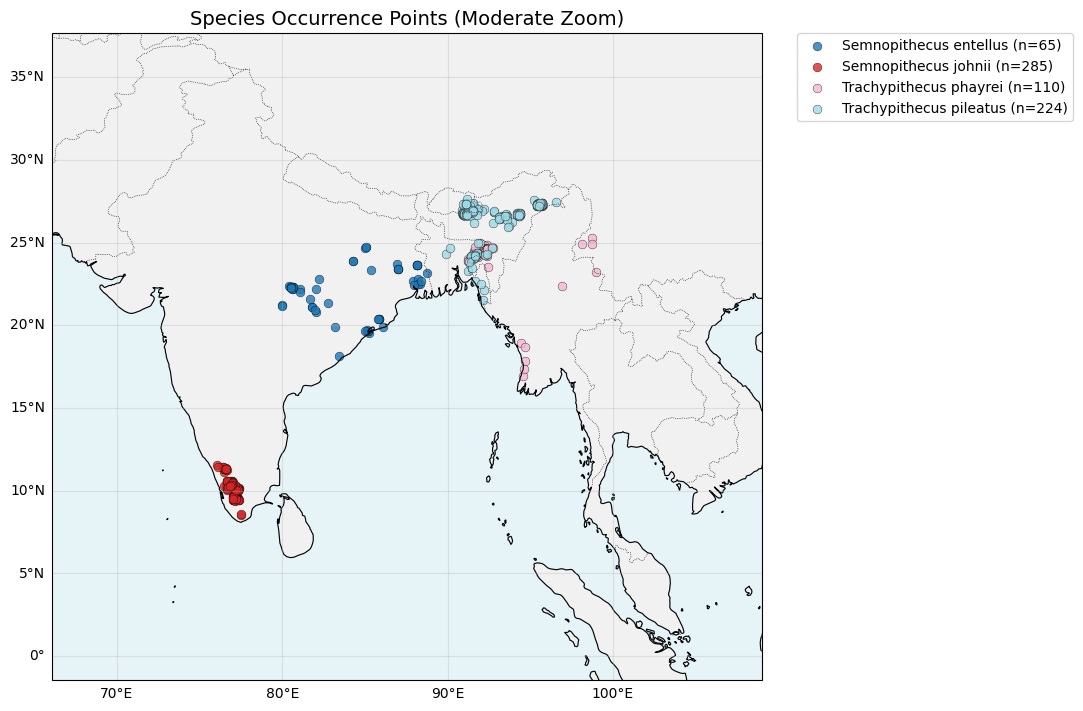


Creating close-up plot...


Saved plot to /Users/divyadhole/Capstone-project/outputs/occurrence_points_closeup.png


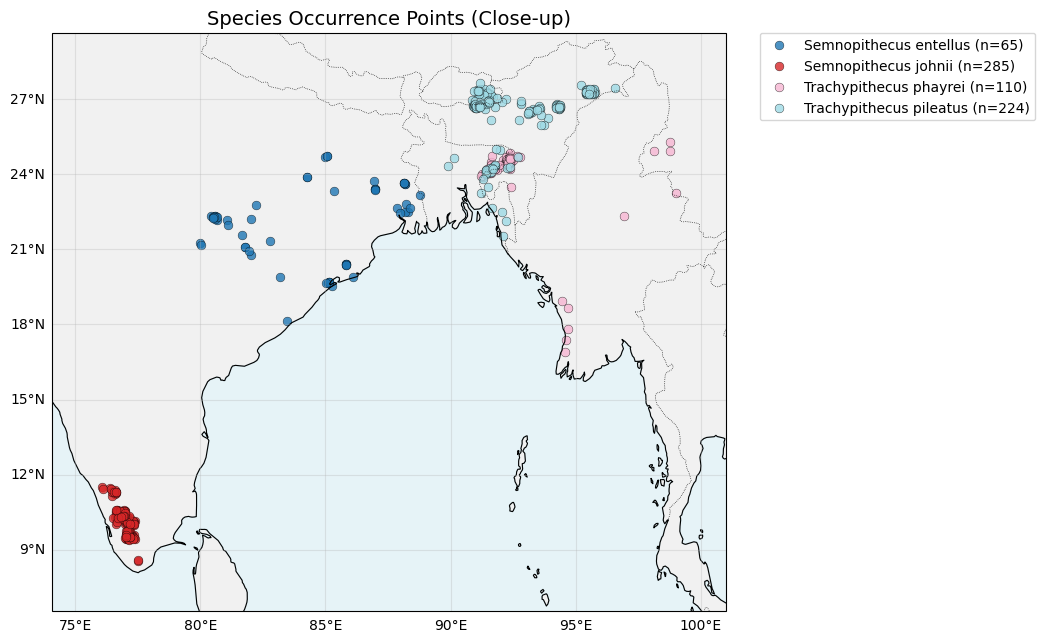

In [11]:
# Import required libraries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
from pathlib import Path

# Set up paths
PROJECT_ROOT = Path.cwd().parent
OUTPUT_DIR = PROJECT_ROOT / "outputs"
OUTPUT_DIR.mkdir(exist_ok=True)

# Load the data
def load_occurrence_data():
    cleaned_path = PROJECT_ROOT / "outputs" / "cleaned_occurrences.csv"
    validated_path = OUTPUT_DIR / "validated_occurrences.csv"
    
    if validated_path.exists():
        df = pd.read_csv(validated_path)
        print(f"Loaded {len(df)} validated occurrence points")
    elif cleaned_path.exists():
        df = pd.read_csv(cleaned_path)
        print(f"Loaded {len(df)} cleaned occurrence points")
    else:
        gbif_path = PROJECT_ROOT / "outputs" / "occurrence_points_gbif.csv"
        if gbif_path.exists():
            df = pd.read_csv(gbif_path)
            print(f"Loaded {len(df)} raw GBIF occurrence points")
        else:
            raise FileNotFoundError("No occurrence data found.")
    return df

def create_occurrence_plot(df, extent, title, filename, padding=5, figsize=(10, 8)):
    """
    Create a single occurrence plot with the specified extent.
    
    Parameters:
    - df: DataFrame with occurrence data
    - extent: [min_lon, max_lon, min_lat, max_lat]
    - title: Plot title
    - filename: Output filename
    - padding: Additional padding around points (in degrees)
    - figsize: Figure size
    """
    species_list = np.sort(df['scientific_name'].unique())
    n_species = len(species_list)
    colors = plt.cm.tab20(np.linspace(0, 1, n_species))
    
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Plot points
    for i, species in enumerate(species_list):
        points = df[df['scientific_name'] == species]
        if not points.empty:
            ax.scatter(
                points['longitude'], 
                points['latitude'],
                c=[colors[i]], 
                s=40, 
                alpha=0.8,
                label=f'{species} (n={len(points)})',
                transform=ccrs.PlateCarree(),
                edgecolor='k',
                linewidth=0.3
            )
    
    # Add map features
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.3)
    ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, alpha=0.3)
    gl.top_labels = False
    gl.right_labels = False
    
    # Add legend
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.,
        fontsize=10
    )
    
    plt.title(title, fontsize=14)
    plt.tight_layout()
    
    # Save the plot
    plot_path = OUTPUT_DIR / filename
    plt.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Saved plot to {plot_path}")
    
    plt.show()

def main():
    # Load data
    try:
        df = load_occurrence_data()
    except Exception as e:
        print(f"Error loading data: {e}")
        return
    
    # Calculate data extent with some padding
    def calculate_extent(df, padding_degrees):
        min_lon, max_lon = df['longitude'].min(), df['longitude'].max()
        min_lat, max_lat = df['latitude'].min(), df['latitude'].max()
        return [
            min_lon - padding_degrees,
            max_lon + padding_degrees,
            min_lat - padding_degrees,
            max_lat + padding_degrees
        ]
    
    # Plot 1: Moderate zoom (10 degrees padding)
    print("\nCreating moderate zoom plot...")
    moderate_extent = calculate_extent(df, padding_degrees=10)
    create_occurrence_plot(
        df,
        extent=moderate_extent,
        title="Species Occurrence Points (Moderate Zoom)",
        filename="occurrence_points_moderate_zoom.png"
    )
    
    # Plot 2: Close zoom (2 degrees padding)
    print("\nCreating close-up plot...")
    close_extent = calculate_extent(df, padding_degrees=2)
    create_occurrence_plot(
        df,
        extent=close_extent,
        title="Species Occurrence Points (Close-up)",
        filename="occurrence_points_closeup.png",
        figsize=(10, 8)
    )

if __name__ == "__main__":
    main()

## Step 6 : Climate Data Processing

In [12]:
import os
import rasterio
import numpy as np
from tqdm import tqdm
import pandas as pd
from pathlib import Path

# 1. Load the validated occurrence data
validated_path = PROJECT_ROOT / "outputs" / "validated_occurrences.csv"
occurrences = pd.read_csv(validated_path)

# 2. Define climate variables (WorldClim bioclimatic variables)
climate_vars = [
    'bio1',  # Annual Mean Temperature
    'bio4',  # Temperature Seasonality
    'bio12',  # Annual Precipitation
    'bio15',  # Precipitation Seasonality
]

# 3. Function to extract climate data
def extract_climate_data(points, climate_dir, time_period):
    """
    Extract climate data for given points from raster files.
    
    Args:
        points: DataFrame with 'longitude' and 'latitude' columns
        climate_dir: Directory containing climate rasters
        time_period: Name of the time period (for output)
    
    Returns:
        DataFrame with extracted climate data
    """
    # Make a copy to avoid modifying the original
    result = points.copy()
    
    # Create output directory if it doesn't exist
    output_dir = PROJECT_ROOT / "outputs" / "climate" / time_period
    os.makedirs(output_dir, exist_ok=True)
    
    # Process each climate variable
    for var in tqdm(climate_vars, desc=f"Processing {time_period}"):
        # Build the path to the raster file
        raster_path = climate_dir / f"{var}.tif"
        
        try:
            # Open the raster file
            with rasterio.open(raster_path) as src:
                # Convert lat/lon to raster coordinates
                coords = [(lon, lat) for lon, lat in zip(points['longitude'], points['latitude'])]
                # Sample the raster at each point
                values = [x[0] for x in src.sample(coords)]
                
                # Handle no-data values
                values = [np.nan if v == src.nodata else v for v in values]
                
                # Add to results
                result[f"{var}_{time_period}"] = values
                
        except Exception as e:
            print(f"Error processing {raster_path}: {e}")
            result[f"{var}_{time_period}"] = np.nan
    
    # Save the results
    output_path = output_dir / f"climate_data_{time_period}.csv"
    result.to_csv(output_path, index=False)
    print(f"Saved climate data for {time_period} to {output_path}")
    
    return result

# 4. Process data for each time period
time_periods = {
    "current": PROJECT_ROOT / "data" / "paleoclim" / "10min",
    "EH": PROJECT_ROOT / "data" / "paleoclim" / "EH_v1_2_5m",
    "LGM": PROJECT_ROOT / "data" / "paleoclim" / "LGM_v1_2_5m"
}

# Dictionary to store results
climate_data = {}

# Process each time period
for period, path in time_periods.items():
    if path.exists():
        climate_data[period] = extract_climate_data(occurrences, path, period)
    else:
        print(f"Warning: Climate data directory not found: {path}")

print("\nClimate data extraction complete!")

# 5. Optional: Combine all time periods into a single DataFrame
if climate_data:
    # Start with the current climate data
    combined = climate_data["current"].copy()
    
    # Add columns from other time periods
    for period, df in climate_data.items():
        if period != "current":
            # Get only the climate variable columns
            cols = [c for c in df.columns if c.endswith(f"_{period}")]
            for col in cols:
                combined[col] = df[col]
    
    # Save the combined data
    combined_path = PROJECT_ROOT / "outputs" / "climate" / "combined_climate_data.csv"
    combined.to_csv(combined_path, index=False)
    print(f"\nSaved combined climate data to {combined_path}")
    
    # Display a sample of the combined data
    print("\nSample of combined climate data:")
    print(combined.head())
else:
    print("No climate data was processed. Please check the input directories.")

Processing current:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:GDAL signalled an error: err_no=4, msg='/Users/divyadhole/Capstone-project/data/paleoclim/10min/bio1.tif: No such file or directory'


INFO:GDAL signalled an error: err_no=4, msg='/Users/divyadhole/Capstone-project/data/paleoclim/10min/bio4.tif: No such file or directory'


INFO:GDAL signalled an error: err_no=4, msg='/Users/divyadhole/Capstone-project/data/paleoclim/10min/bio12.tif: No such file or directory'


INFO:GDAL signalled an error: err_no=4, msg='/Users/divyadhole/Capstone-project/data/paleoclim/10min/bio15.tif: No such file or directory'


Processing current: 100%|██████████| 4/4 [00:00<00:00, 118.31it/s]

Error processing /Users/divyadhole/Capstone-project/data/paleoclim/10min/bio1.tif: /Users/divyadhole/Capstone-project/data/paleoclim/10min/bio1.tif: No such file or directory
Error processing /Users/divyadhole/Capstone-project/data/paleoclim/10min/bio4.tif: /Users/divyadhole/Capstone-project/data/paleoclim/10min/bio4.tif: No such file or directory
Error processing /Users/divyadhole/Capstone-project/data/paleoclim/10min/bio12.tif: /Users/divyadhole/Capstone-project/data/paleoclim/10min/bio12.tif: No such file or directory
Error processing /Users/divyadhole/Capstone-project/data/paleoclim/10min/bio15.tif: /Users/divyadhole/Capstone-project/data/paleoclim/10min/bio15.tif: No such file or directory
Saved climate data for current to /Users/divyadhole/Capstone-project/outputs/climate/current/climate_data_current.csv


Processing EH:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:GDAL signalled an error: err_no=4, msg='/Users/divyadhole/Capstone-project/data/paleoclim/EH_v1_2_5m/bio1.tif: No such file or directory'


INFO:GDAL signalled an error: err_no=4, msg='/Users/divyadhole/Capstone-project/data/paleoclim/EH_v1_2_5m/bio4.tif: No such file or directory'


INFO:GDAL signalled an error: err_no=4, msg='/Users/divyadhole/Capstone-project/data/paleoclim/EH_v1_2_5m/bio12.tif: No such file or directory'


INFO:GDAL signalled an error: err_no=4, msg='/Users/divyadhole/Capstone-project/data/paleoclim/EH_v1_2_5m/bio15.tif: No such file or directory'


Processing EH: 100%|██████████| 4/4 [00:00<00:00, 581.05it/s]

Error processing /Users/divyadhole/Capstone-project/data/paleoclim/EH_v1_2_5m/bio1.tif: /Users/divyadhole/Capstone-project/data/paleoclim/EH_v1_2_5m/bio1.tif: No such file or directory
Error processing /Users/divyadhole/Capstone-project/data/paleoclim/EH_v1_2_5m/bio4.tif: /Users/divyadhole/Capstone-project/data/paleoclim/EH_v1_2_5m/bio4.tif: No such file or directory
Error processing /Users/divyadhole/Capstone-project/data/paleoclim/EH_v1_2_5m/bio12.tif: /Users/divyadhole/Capstone-project/data/paleoclim/EH_v1_2_5m/bio12.tif: No such file or directory
Error processing /Users/divyadhole/Capstone-project/data/paleoclim/EH_v1_2_5m/bio15.tif: /Users/divyadhole/Capstone-project/data/paleoclim/EH_v1_2_5m/bio15.tif: No such file or directory
Saved climate data for EH to /Users/divyadhole/Capstone-project/outputs/climate/EH/climate_data_EH.csv


Processing LGM:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:GDAL signalled an error: err_no=4, msg='/Users/divyadhole/Capstone-project/data/paleoclim/LGM_v1_2_5m/bio1.tif: No such file or directory'


INFO:GDAL signalled an error: err_no=4, msg='/Users/divyadhole/Capstone-project/data/paleoclim/LGM_v1_2_5m/bio4.tif: No such file or directory'


INFO:GDAL signalled an error: err_no=4, msg='/Users/divyadhole/Capstone-project/data/paleoclim/LGM_v1_2_5m/bio12.tif: No such file or directory'


INFO:GDAL signalled an error: err_no=4, msg='/Users/divyadhole/Capstone-project/data/paleoclim/LGM_v1_2_5m/bio15.tif: No such file or directory'


Processing LGM: 100%|██████████| 4/4 [00:00<00:00, 567.37it/s]

Error processing /Users/divyadhole/Capstone-project/data/paleoclim/LGM_v1_2_5m/bio1.tif: /Users/divyadhole/Capstone-project/data/paleoclim/LGM_v1_2_5m/bio1.tif: No such file or directory
Error processing /Users/divyadhole/Capstone-project/data/paleoclim/LGM_v1_2_5m/bio4.tif: /Users/divyadhole/Capstone-project/data/paleoclim/LGM_v1_2_5m/bio4.tif: No such file or directory
Error processing /Users/divyadhole/Capstone-project/data/paleoclim/LGM_v1_2_5m/bio12.tif: /Users/divyadhole/Capstone-project/data/paleoclim/LGM_v1_2_5m/bio12.tif: No such file or directory
Error processing /Users/divyadhole/Capstone-project/data/paleoclim/LGM_v1_2_5m/bio15.tif: /Users/divyadhole/Capstone-project/data/paleoclim/LGM_v1_2_5m/bio15.tif: No such file or directory
Saved climate data for LGM to /Users/divyadhole/Capstone-project/outputs/climate/LGM/climate_data_LGM.csv

Climate data extraction complete!

Saved combined climate data to /Users/divyadhole/Capstone-project/outputs/climate/combined_climate_data.cs

## Step 7 :  load climate raster

In [13]:
def load_climate_raster(climate_file, variable_name):
    """
    Load a climate raster (GeoTIFF) into memory with enhanced error handling.
    
    Args:
        climate_file (str): Path to the GeoTIFF file
        variable_name (str): Name of the climate variable
        
    Returns:
        dict: Dictionary containing:
            - data: 2D numpy array of climate data
            - transform: Affine transform for georeferencing
            - crs: Coordinate reference system
            - bounds: Bounding box of the raster
            - variable: Name of the climate variable
            - nodata: NoData value from the raster
            
    Raises:
        FileNotFoundError: If the climate file doesn't exist
        rasterio.errors.RasterioError: For issues reading the raster
    """
    import os
    import numpy as np
    import rasterio
    from rasterio.errors import RasterioError
    
    if not os.path.exists(climate_file):
        raise FileNotFoundError(f"Climate file not found: {climate_file}")
    
    try:
        with rasterio.open(climate_file) as src:
            # Read the first band by default
            data = src.read(1)
            
            # Get metadata
            transform = src.transform
            crs = src.crs
            bounds = src.bounds
            nodata = src.nodata if src.nodata is not None else np.nan
            
            # Print basic info for verification
            print(f"Loaded {variable_name} raster:")
            print(f"  - Shape: {data.shape}")
            print(f"  - Bounds: {bounds}")
            print(f"  - CRS: {crs}")
            print(f"  - NoData value: {nodata}")
            print(f"  - Min value: {np.nanmin(data[data != nodata]):.2f}")
            print(f"  - Max value: {np.nanmax(data[data != nodata]):.2f}")
            
            # Replace NoData values with NaN for easier handling
            if not np.isnan(nodata):
                data = np.where(data == nodata, np.nan, data)
            
            return {
                "data": data,
                "transform": transform,
                "crs": crs,
                "bounds": bounds,
                "variable": variable_name,
                "nodata": nodata
            }
            
    except RasterioError as e:
        print(f"Error reading raster file {climate_file}: {str(e)}")
        raise


def extract_climate_at_points(climate_raster, points_df, lat_col='latitude', lon_col='longitude'):
    """
    Sample climate values at each latitude/longitude in points_df with enhanced validation.
    
    Args:
        climate_raster (dict): Dictionary from load_climate_raster()
        points_df (pd.DataFrame): DataFrame containing point coordinates
        lat_col (str): Name of the latitude column
        lon_col (str): Name of the longitude column
        
    Returns:
        tuple: (values, valid_indices, stats) where:
            - values: Array of climate values at valid points
            - valid_indices: Indices of points that were successfully sampled
            - stats: Dictionary with sampling statistics
    """
    import numpy as np
    from rasterio.transform import rowcol
    
    if not all(col in points_df.columns for col in [lat_col, lon_col]):
        raise ValueError(f"points_df must contain columns: {lat_col}, {lon_col}")
    
    values = []
    valid_indices = []
    out_of_bounds = 0
    nodata_count = 0
    
    # Pre-compute raster properties
    height, width = climate_raster["data"].shape
    transform = climate_raster["transform"]
    data = climate_raster["data"]
    
    for idx, (_, row) in enumerate(points_df.iterrows()):
        lon, lat = row[lon_col], row[lat_col]
        
        try:
            # Convert lat/lon to row/col indices
            row_idx, col_idx = rowcol(transform, lon, lat)
            
            # Check if the point is within raster bounds
            if 0 <= row_idx < height and 0 <= col_idx < width:
                value = data[row_idx, col_idx]
                
                # Check for NoData values
                if not np.isnan(value):
                    values.append(value)
                    valid_indices.append(idx)
                else:
                    nodata_count += 1
            else:
                out_of_bounds += 1
                
        except Exception as e:
            print(f"Error processing point {idx} (lat: {lat}, lon: {lon}): {str(e)}")
            continue
    
    # Calculate statistics
    stats = {
        'total_points': len(points_df),
        'valid_points': len(valid_indices),
        'out_of_bounds': out_of_bounds,
        'nodata_count': nodata_count,
        'success_rate': len(valid_indices) / len(points_df) if len(points_df) > 0 else 0
    }
    
    print("\nSampling Statistics:")
    print(f"  - Total points: {stats['total_points']}")
    print(f"  - Successfully sampled: {stats['valid_points']} ({stats['success_rate']*100:.1f}%)")
    print(f"  - Out of bounds: {stats['out_of_bounds']}")
    print(f"  - NoData values: {stats['nodata_count']}")
    
    return np.array(values), valid_indices, stats


# Example usage:
"""
# Load climate data
climate_data = load_climate_raster('path/to/climate.tif', 'temperature')

# Sample points
values, valid_indices, stats = extract_climate_at_points(
    climate_data, 
    points_df,
    lat_col='latitude',
    lon_col='longitude'
)

# Add sampled values back to original dataframe
points_df['climate_value'] = np.nan
points_df.loc[valid_indices, 'climate_value'] = values
"""

"\n# Load climate data\nclimate_data = load_climate_raster('path/to/climate.tif', 'temperature')\n\n# Sample points\nvalues, valid_indices, stats = extract_climate_at_points(\n    climate_data, \n    points_df,\n    lat_col='latitude',\n    lon_col='longitude'\n)\n\n# Add sampled values back to original dataframe\npoints_df['climate_value'] = np.nan\npoints_df.loc[valid_indices, 'climate_value'] = values\n"

## Step 8: Climate Data Processing

In [14]:
# Step 5: Climate Data Processing
def load_climate_data(climate_dir):
    """Load and process climate data from NetCDF files."""
    print("\nLoading climate data...")
    climate_files = list(Path(climate_dir).glob("*.nc"))
    if not climate_files:
        print(f"No NetCDF files found in {climate_dir}")
        return None
    
    # Load the first file to get the structure
    ds = xr.open_dataset(climate_files[0])
    print(f"Loaded climate data with variables: {list(ds.data_vars)}")
    return ds

def extract_climate_at_points(climate_data, points_df, var_names=None):
    """
    Extract climate values at occurrence points.
    
    Args:
        climate_data: xarray Dataset with climate data
        points_df: DataFrame with 'latitude' and 'longitude' columns
        var_names: List of variable names to extract (if None, extract all)
    
    Returns:
        DataFrame with climate values for each point
    """
    if var_names is None:
        var_names = list(climate_data.data_vars)
    
    # Create a copy of the points dataframe
    result_df = points_df.copy()
    
    # Convert points to xarray compatible format
    lats = xr.DataArray(points_df['latitude'].values, dims='point')
    lons = xr.DataArray(points_df['longitude'].values, dims='point')
    
    # Extract values for each variable
    for var in var_names:
        if var in climate_data:
            # Use nearest neighbor interpolation
            values = climate_data[var].sel(
                latitude=lats,
                longitude=lons,
                method='nearest'
            )
            result_df[var] = values.values
    
    return result_df





## Step 9 : Climate Time Series Analysis

In [15]:
# Climate Time Series Analysis
def create_climate_time_series(climate_dir, time_periods, variables, points_df):
    """
    Create a time series of climate variables for the given points.
    
    Args:
        climate_dir: Directory containing climate data files
        time_periods: List of time periods (file name patterns)
        variables: List of climate variables to include
        points_df: DataFrame with occurrence points
    
    Returns:
        DataFrame with mean climate values for each time period
    """
    results = []
    
    for period in time_periods:
        # Find the climate file for this time period
        pattern = f"*{period}*.nc"
        try:
            file_path = next(Path(climate_dir).glob(pattern))
        except StopIteration:
            print(f"No file found matching pattern: {pattern}")
            continue
            
        print(f"Processing {file_path.name}...")
        
        # Load the climate data
        ds = xr.open_dataset(file_path)
        
        # Extract values at points
        climate_values = extract_climate_at_points(ds, points_df, variables)
        
        # Calculate mean values across all points
        mean_values = climate_values[variables].mean().to_dict()
        mean_values['time_ka'] = float(period)
        
        results.append(mean_values)
    
    return pd.DataFrame(results)





In [16]:
def create_climate_time_series(period_folders, variables, occurrences_df):
    """
    Aggregate climate values for each time period across all occurrence points.
    
    Args:
        period_folders (dict): Maps time periods (ka) to folder paths containing climate data
        variables (list): List of climate variables to extract (e.g., ['bio1', 'bio12'])
        occurrences_df (pd.DataFrame): DataFrame containing occurrence points with 'latitude' and 'longitude' columns
        
    Returns:
        pd.DataFrame: Time series data with climate statistics for each period
    """
    import pandas as pd
    import numpy as np
    from pathlib import Path
    from tqdm import tqdm
    import warnings
    warnings.filterwarnings('ignore', message='invalid value encountered in scalar divide')
    
    time_series_data = []
    total_periods = len(period_folders)
    
    print(f"Processing {total_periods} time periods with {len(variables)} variables each...")
    
    for period, folder in tqdm(period_folders.items(), desc="Processing time periods"):
        period_data = {"time_period": period}
        folder = Path(folder) if folder else None

        if folder is None or not folder.exists():
            print(f"\nWarning: folder for {period}ka not found ({folder})")
            time_series_data.append(period_data)
            continue

        period_results = {}
        
        for var in variables:
            # Handle both 'bio1' and 'bio_1' naming conventions
            if var.startswith('bio'):
                var_num = var[3:]  # Extract number from 'bio1'
                tif_name = f"bio_{var_num}.tif"
            else:
                tif_name = f"{var}.tif"
                
            file_path = folder / tif_name

            if not file_path.exists():
                # Try alternative naming convention
                alt_tif_name = f"{var}.tif" if var.startswith('bio') else f"bio_{var}.tif"
                file_path = folder / alt_tif_name
                
                if not file_path.exists():
                    print(f"\nWarning: raster {tif_name} not found in {folder}")
                    continue

            try:
                # Load and process the raster
                raster = load_climate_raster(str(file_path), var)
                values, valid_indices, stats = extract_climate_at_points(raster, occurrences_df)
                
                if len(values) > 0:
                    # Calculate statistics
                    period_data.update({
                        f"{var}_mean": np.nanmean(values),
                        f"{var}_std": np.nanstd(values),
                        f"{var}_min": np.nanmin(values),
                        f"{var}_max": np.nanmax(values),
                        f"{var}_n": len(values)
                    })
                    print(f"  - {var}: {len(values)} valid points")
                else:
                    print(f"\nWarning: no valid samples for {var} at {period}ka")
                    
            except Exception as e:
                print(f"\nError processing {var} at {period}ka: {str(e)}")
                continue

        time_series_data.append(period_data)

    # Create DataFrame and clean up
    df = pd.DataFrame(time_series_data)
    
    # Sort by time period (most recent first)
    df = df.sort_values('time_period', ascending=False)
    
    # Add years column
    df['time_years'] = df['time_period'] * 1000
    
    return df

# Configuration
period_folders = {
    0: DATA_DIR / "paleoclim" / "LH_v1_2_5m",  # Late Holocene
    6: DATA_DIR / "paleoclim" / "MH_v1_2_5m",   # Mid Holocene
    12: DATA_DIR / "paleoclim" / "EH_v1_2_5m",  # Early Holocene
    21: DATA_DIR / "paleoclim" / "LGM_v1_2_5m", # Last Glacial Maximum
}

# Get variables from config or use defaults
variables = config.get("climate_data", {}).get("variables", ["bio1", "bio12"])

# Process the data if occurrences exist
if 'occurrences_gbif' in locals() and not occurrences_gbif.empty:
    print(f"Processing climate data for {len(occurrences_gbif)} occurrence points...")
    
    # Run the time series creation
    climate_series = create_climate_time_series(period_folders, variables, occurrences_gbif)
    
    # Save results
    results_csv = OUTPUT_DIR / "climate_time_series.csv"
    climate_series.to_csv(results_csv, index=False)
    
    # Print summary
    print(f"\nClimate time series created with {len(climate_series)} time periods")
    print(f"Results saved to: {results_csv}")
    
    # Display the first few rows
    display(climate_series.head())
    
    # Basic validation
    print("\nSummary statistics:")
    print(climate_series.describe())
    
else:
    print("Cannot create climate time series. Occurrence data is missing or empty.")
    print("Please run the occurrence data processing steps first.")

Processing climate data for 684 occurrence points...
Processing 4 time periods with 2 variables each...


Processing time periods:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded bio1 raster:
  - Shape: (4176, 8640)
  - Bounds: BoundingBox(left=-180.00013888885002, bottom=-90.00013888884999, right=179.99985967115003, top=83.99986041515004)
  - CRS: EPSG:4326
  - NoData value: -32768.0


  - Min value: -526.00
  - Max value: 314.00



Error processing bio1 at 0ka: 'dict' object has no attribute 'data_vars'


Loaded bio12 raster:
  - Shape: (4176, 8640)
  - Bounds: BoundingBox(left=-180.00013888885002, bottom=-90.00013888884999, right=179.99985967115003, top=83.99986041515004)
  - CRS: EPSG:4326
  - NoData value: 65535.0
  - Min value: 0.00
  - Max value: 11010.00


Processing time periods:  25%|██▌       | 1/4 [00:01<00:04,  1.67s/it]


Error processing bio12 at 0ka: 'dict' object has no attribute 'data_vars'


Loaded bio1 raster:
  - Shape: (4285, 8640)
  - Bounds: BoundingBox(left=-180.0, bottom=-90.0000000000002, right=180.00000000000028, top=88.5416666666666)
  - CRS: EPSG:4326
  - NoData value: -32768.0
  - Min value: -533.00
  - Max value: 302.00



Error processing bio1 at 6ka: 'dict' object has no attribute 'data_vars'


Loaded bio12 raster:
  - Shape: (4285, 8640)
  - Bounds: BoundingBox(left=-180.0, bottom=-90.0000000000002, right=180.00000000000028, top=88.5416666666666)
  - CRS: EPSG:4326
  - NoData value: 65535.0
  - Min value: 0.00
  - Max value: 11039.00


Processing time periods:  50%|█████     | 2/4 [00:03<00:03,  1.58s/it]


Error processing bio12 at 6ka: 'dict' object has no attribute 'data_vars'


Loaded bio1 raster:
  - Shape: (4285, 8640)
  - Bounds: BoundingBox(left=-180.0, bottom=-90.0000000000002, right=180.00000000000028, top=88.5416666666666)
  - CRS: EPSG:4326
  - NoData value: -32768.0
  - Min value: -553.00
  - Max value: 301.00



Error processing bio1 at 12ka: 'dict' object has no attribute 'data_vars'


Loaded bio12 raster:
  - Shape: (4285, 8640)
  - Bounds: BoundingBox(left=-180.0, bottom=-90.0000000000002, right=180.00000000000028, top=88.5416666666666)
  - CRS: EPSG:4326
  - NoData value: 65535.0
  - Min value: 0.00
  - Max value: 11103.00


Processing time periods:  75%|███████▌  | 3/4 [00:04<00:01,  1.49s/it]


Error processing bio12 at 12ka: 'dict' object has no attribute 'data_vars'


Loaded bio1 raster:
  - Shape: (4320, 8640)
  - Bounds: BoundingBox(left=-179.99999999995, bottom=-89.99999999995002, right=180.00000000005028, top=90.00000000005012)
  - CRS: EPSG:4326
  - NoData value: -32768.0
  - Min value: -800.00
  - Max value: 281.00



Error processing bio1 at 21ka: 'dict' object has no attribute 'data_vars'


Loaded bio12 raster:
  - Shape: (4320, 8640)
  - Bounds: BoundingBox(left=-179.99999999995, bottom=-89.99999999995002, right=180.00000000005028, top=90.00000000005012)
  - CRS: EPSG:4326
  - NoData value: 65535.0
  - Min value: 0.00


  - Max value: 3276.00


Processing time periods: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]

Processing time periods: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]


Error processing bio12 at 21ka: 'dict' object has no attribute 'data_vars'

Climate time series created with 4 time periods
Results saved to: /Users/divyadhole/Capstone-project/outputs/climate_time_series.csv


,time_period,time_years
3,21,21000
2,12,12000
1,6,6000
0,0,0



Summary statistics:
       time_period    time_years
count     4.000000      4.000000
mean      9.750000   9750.000000
std       8.958236   8958.236434
min       0.000000      0.000000
25%       4.500000   4500.000000
50%       9.000000   9000.000000
75%      14.250000  14250.000000
max      21.000000  21000.000000


In [17]:
def create_climate_time_series(period_folders, variables, occurrences_df):
    """
    Aggregate climate values for each time period across all occurrence points.
    
    Args:
        period_folders (dict): Maps time periods (ka) to folder paths containing climate data
        variables (list): List of climate variables to extract (e.g., ['bio1', 'bio12'])
        occurrences_df (pd.DataFrame): DataFrame containing occurrence points with 'latitude' and 'longitude' columns
        
    Returns:
        pd.DataFrame: Time series data with climate statistics for each period
    """
    import pandas as pd
    import numpy as np
    from pathlib import Path
    from tqdm import tqdm
    import warnings
    warnings.filterwarnings('ignore', message='invalid value encountered in scalar divide')
    
    time_series_data = []
    total_periods = len(period_folders)
    
    print(f"Processing {total_periods} time periods with {len(variables)} variables each...")
    
    for period, folder in tqdm(period_folders.items(), desc="Processing time periods"):
        period_data = {"time_period": period}
        folder = Path(folder) if folder else None

        if folder is None or not folder.exists():
            print(f"\nWarning: folder for {period}ka not found ({folder})")
            time_series_data.append(period_data)
            continue

        for var in variables:
            # Handle both 'bio1' and 'bio_1' naming conventions
            if var.startswith('bio'):
                var_num = var[3:]  # Extract number from 'bio1'
                tif_name = f"bio_{var_num}.tif"
            else:
                tif_name = f"{var}.tif"
                
            file_path = folder / tif_name

            if not file_path.exists():
                # Try alternative naming convention
                alt_tif_name = f"{var}.tif" if var.startswith('bio') else f"bio_{var}.tif"
                file_path = folder / alt_tif_name
                
                if not file_path.exists():
                    print(f"\nWarning: raster {tif_name} not found in {folder}")
                    continue

            try:
                # Load the raster data
                with rasterio.open(file_path) as src:
                    # Get the transform from pixel to coordinates
                    transform = src.transform
                    # Get the CRS
                    crs = src.crs
                    
                    # Extract values at occurrence points
                    values = []
                    for _, row in occurrences_df.iterrows():
                        # Convert lat/lon to pixel coordinates
                        row, col = src.index(row['longitude'], row['latitude'])
                        
                        try:
                            # Read the value
                            value = src.read(1, window=((row, row+1), (col, col+1)))
                            if value[0,0] != src.nodata and not np.isnan(value[0,0]):
                                values.append(value[0,0])
                        except (IndexError, ValueError):
                            continue
                    
                    if values:
                        # Calculate statistics
                        period_data.update({
                            f"{var}_mean": np.mean(values),
                            f"{var}_std": np.std(values),
                            f"{var}_min": np.min(values),
                            f"{var}_max": np.max(values),
                            f"{var}_n": len(values)
                        })
                        print(f"  - {var}: {len(values)} valid points")
                    else:
                        print(f"\nWarning: no valid samples for {var} at {period}ka")
                        
            except Exception as e:
                print(f"\nError processing {var} at {period}ka: {str(e)}")
                continue

        time_series_data.append(period_data)

    # Create DataFrame and clean up
    df = pd.DataFrame(time_series_data)
    
    # Sort by time period (most recent first)
    df = df.sort_values('time_period', ascending=False)
    
    # Add years column
    df['time_years'] = df['time_period'] * 1000
    
    return df

In [18]:
def plot_climate_time_series(climate_df, output_file=None):
    """
    Plot climate variables over time using Matplotlib (static) and Plotly (interactive).
    bio1 = annual mean temperature (°C ×10), bio12 = annual precipitation (mm).
    """
    if climate_df is None or climate_df.empty:
        print("No climate data available to plot.")
        return None

    # Get the list of mean variables
    mean_vars = [col for col in climate_df.columns if col.endswith('_mean')]
    
    if not mean_vars:
        print("No mean values found in the data.")
        return None
    
    # Create a new figure for better visualization
    plt.figure(figsize=(15, 6))
    
    # Plot each variable
    for var in mean_vars:
        var_name = var.replace('_mean', '')
        plt.plot(
            climate_df["time_years"],
            climate_df[var],
            marker="o",
            label=f"{var_name}",
            linewidth=2,
            markersize=8,
        )

    plt.xlabel("Years Before Present", fontsize=12)
    plt.ylabel("Value (bio1: °C ×10, bio12: mm)", fontsize=12)
    plt.title(
        "Climate Time Series\n(bio1 = annual mean temperature, bio12 = annual precipitation)",
        fontsize=14,
        fontweight="bold",
    )
    plt.legend(title="Variable", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.gca().invert_xaxis()  # Invert x-axis to show older to newer
    plt.tight_layout()

    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
        print(f"Saved static plot: {output_file}")

    plt.show()

    # --- Interactive Plotly plot ---
    # Melt the dataframe for Plotly
    melted = pd.melt(
        climate_df,
        id_vars=["time_years", "time_period"],
        value_vars=mean_vars,
        var_name="Variable",
        value_name="Value"
    )
    
    # Create interactive plot
    interactive_fig = px.line(
        melted,
        x="time_years",
        y="Value",
        color="Variable",
        markers=True,
        title="Interactive Climate Time Series",
        labels={
            "time_years": "Years Before Present",
            "Value": "Value (bio1: °C ×10, bio12: mm)",
        },
    )
    
    # Reverse x-axis to show older to newer
    interactive_fig.update_layout(xaxis_autorange="reversed")
    interactive_fig.show()

    return interactive_fig

Processing climate data for 684 occurrence points...
Processing 4 time periods with 2 variables each...


Processing time periods:   0%|          | 0/4 [00:00<?, ?it/s]

  - bio1: 684 valid points


Processing time periods:  25%|██▌       | 1/4 [00:00<00:00,  4.81it/s]

  - bio12: 684 valid points
  - bio1: 684 valid points


Processing time periods:  50%|█████     | 2/4 [00:00<00:00,  6.10it/s]

  - bio12: 684 valid points
  - bio1: 684 valid points


Processing time periods:  75%|███████▌  | 3/4 [00:00<00:00,  7.39it/s]

  - bio12: 684 valid points
  - bio1: 684 valid points


Processing time periods: 100%|██████████| 4/4 [00:00<00:00,  7.53it/s]

Processing time periods: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s]

  - bio12: 684 valid points


Saved static plot: /Users/divyadhole/Capstone-project/outputs/climate_time_series.png


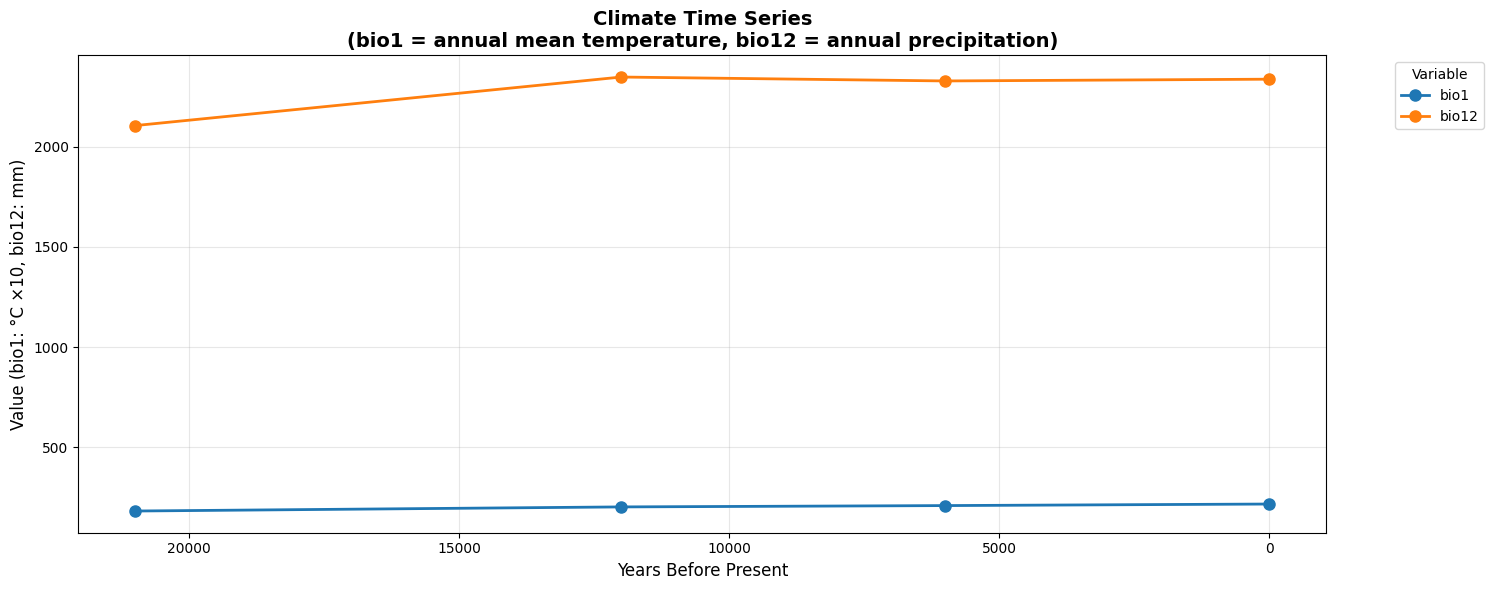


Climate time series created with the following data:
   time_period   bio1_mean   bio1_std  bio1_min  bio1_max  bio1_n  \
3           21  181.046784  32.541573         0       231     684   
2           12  201.574561  31.578807        24       264     684   
1            6  208.209064  30.400906        34       265     684   
0            0  215.937135  30.425787        43       269     684   

    bio12_mean   bio12_std  bio12_min  bio12_max  bio12_n  time_years  
3  2105.947368  533.624504        790       3276      684       21000  
2  2348.426901  678.594524        679       5699      684       12000  
1  2328.856725  673.421913        672       5635      684        6000  
0  2337.663743  674.588680        740       5586      684           0  


In [19]:
import plotly.express as px
import pandas as pd

# Configuration
period_folders = {
    0: DATA_DIR / "paleoclim" / "LH_v1_2_5m",  # Late Holocene
    6: DATA_DIR / "paleoclim" / "MH_v1_2_5m",   # Mid Holocene
    12: DATA_DIR / "paleoclim" / "EH_v1_2_5m",  # Early Holocene
    21: DATA_DIR / "paleoclim" / "LGM_v1_2_5m", # Last Glacial Maximum
}

# Get variables from config or use defaults
variables = ["bio1", "bio12"]

# Process the data if occurrences exist
if 'occurrences_gbif' in locals() and not occurrences_gbif.empty:
    print(f"Processing climate data for {len(occurrences_gbif)} occurrence points...")
    
    # Run the time series creation
    climate_series = create_climate_time_series(period_folders, variables, occurrences_gbif)
    
    # Save results
    results_csv = OUTPUT_DIR / "climate_time_series.csv"
    climate_series.to_csv(results_csv, index=False)
    
    # Plot the results
    plot_climate_time_series(climate_series, OUTPUT_DIR / "climate_time_series.png")
    
    # Display the results
    print("\nClimate time series created with the following data:")
    print(climate_series)
else:
    print("Cannot create climate time series. Occurrence data is missing or empty.")
    print("Please run the occurrence data processing steps first.")

Processing climate data for 684 occurrence points...
Processing 4 time periods with 8 variables each...


Processing time periods:   0%|          | 0/4 [00:00<?, ?it/s]

  - bio1: 684 valid points


  - bio4: 684 valid points


  - bio12: 684 valid points


  - bio15: 684 valid points
  - bio5: 684 valid points


  - bio6: 684 valid points
  - bio13: 684 valid points


Processing time periods:  25%|██▌       | 1/4 [00:01<00:04,  1.35s/it]

  - bio14: 684 valid points
  - bio1: 684 valid points
  - bio4: 684 valid points


  - bio12: 684 valid points
  - bio15: 684 valid points
  - bio5: 684 valid points


Processing time periods:  50%|█████     | 2/4 [00:02<00:02,  1.02s/it]

  - bio6: 684 valid points
  - bio13: 684 valid points
  - bio14: 684 valid points


  - bio1: 684 valid points
  - bio4: 684 valid points
  - bio12: 684 valid points


  - bio15: 684 valid points
  - bio5: 684 valid points
  - bio6: 684 valid points


Processing time periods:  75%|███████▌  | 3/4 [00:02<00:00,  1.11it/s]

  - bio13: 684 valid points
  - bio14: 684 valid points
  - bio1: 684 valid points


  - bio4: 684 valid points
  - bio12: 684 valid points
  - bio15: 684 valid points


  - bio5: 684 valid points
  - bio6: 684 valid points
  - bio13: 684 valid points


Processing time periods: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

Processing time periods: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

  - bio14: 684 valid points


Saved static plot: /Users/divyadhole/Capstone-project/outputs/climate_time_series.png


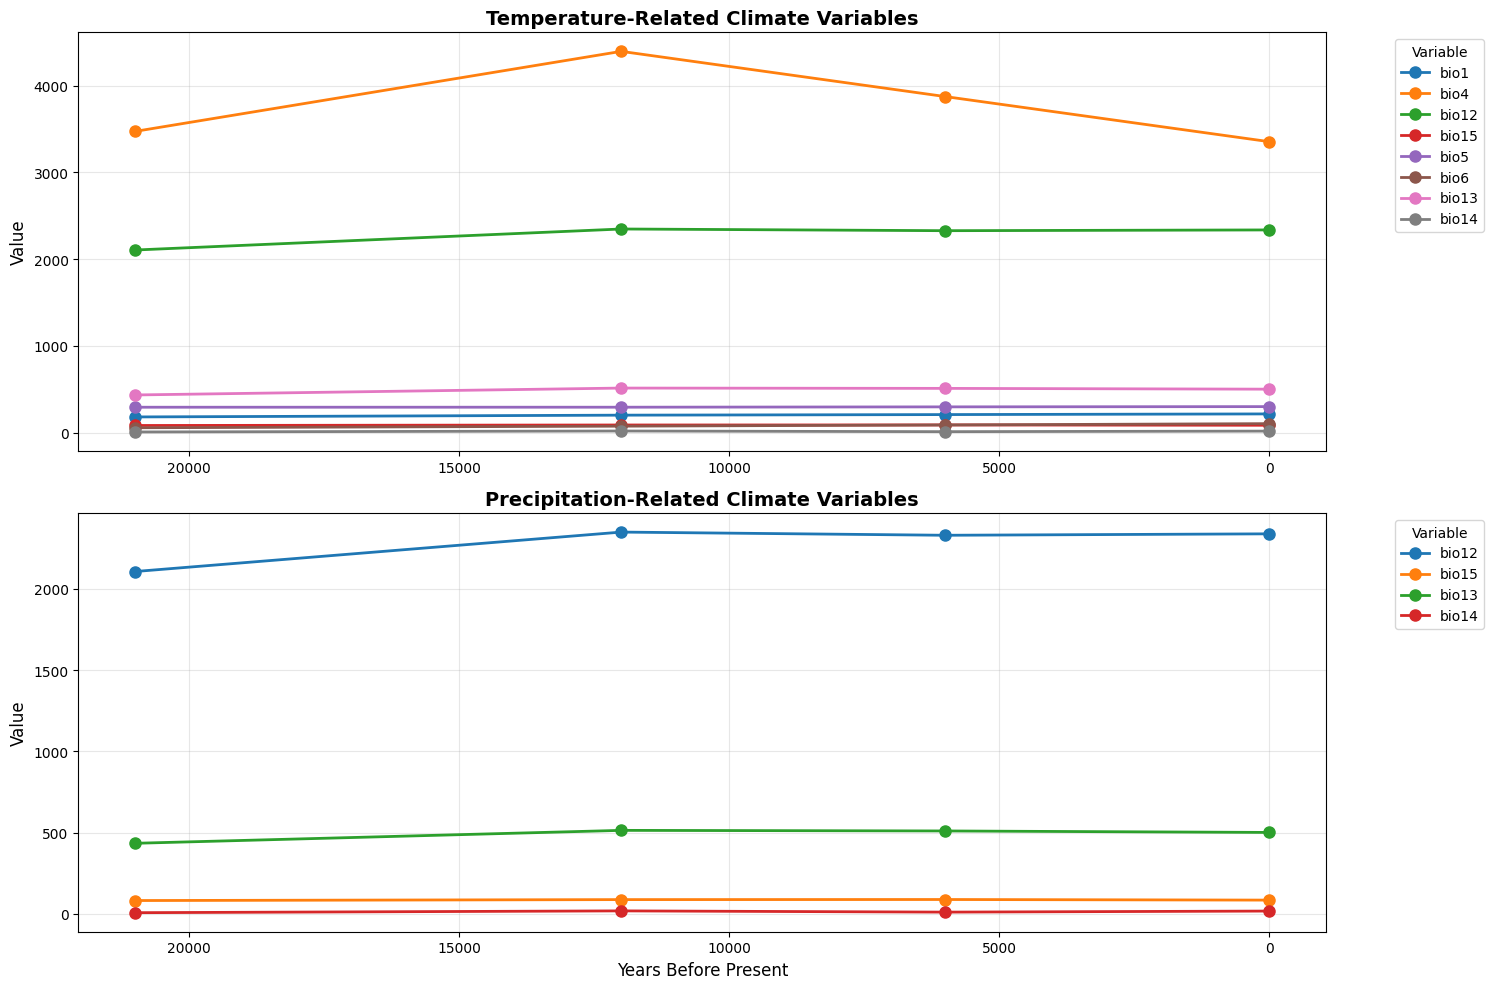


Climate time series created with the following data:
   time_period  time_years   bio1_mean    bio4_mean   bio12_mean  bio15_mean  \
3           21       21000  181.046784  3474.067251  2105.947368   82.454678   
2           12       12000  201.574561  4396.918129  2348.426901   88.236842   
1            6        6000  208.209064  3875.543860  2328.856725   88.815789   
0            0           0  215.937135  3355.311404  2337.663743   85.115497   

    bio5_mean   bio6_mean  bio13_mean  bio14_mean  
3  293.052632   56.191520  434.502924    7.733918  
2  293.328947   74.747076  514.026316   18.843567  
1  297.162281   88.570175  510.418129   11.235380  
0  300.135965  103.742690  501.276316   17.729532  


In [20]:
# Configuration
period_folders = {
    0: DATA_DIR / "paleoclim" / "LH_v1_2_5m",  # Late Holocene
    6: DATA_DIR / "paleoclim" / "MH_v1_2_5m",   # Mid Holocene
    12: DATA_DIR / "paleoclim" / "EH_v1_2_5m",  # Early Holocene
    21: DATA_DIR / "paleoclim" / "LGM_v1_2_5m", # Last Glacial Maximum
}

# Add more variables to analyze
variables = [
    "bio1",   # Annual Mean Temperature
    "bio4",   # Temperature Seasonality
    "bio12",  # Annual Precipitation
    "bio15",  # Precipitation Seasonality
    "bio5",   # Max Temperature of Warmest Month
    "bio6",   # Min Temperature of Coldest Month
    "bio13",  # Precipitation of Wettest Month
    "bio14"   # Precipitation of Driest Month
]

def create_climate_time_series(period_folders, variables, occurrences_df):
    """
    Aggregate climate values for each time period across all occurrence points.
    """
    import pandas as pd
    import numpy as np
    import rasterio
    from pathlib import Path
    from tqdm import tqdm
    import warnings
    warnings.filterwarnings('ignore', message='invalid value encountered in scalar divide')
    
    time_series_data = []
    
    print(f"Processing {len(period_folders)} time periods with {len(variables)} variables each...")
    
    for period, folder in tqdm(period_folders.items(), desc="Processing time periods"):
        period_data = {"time_period": period}
        folder = Path(folder) if folder else None

        if folder is None or not folder.exists():
            print(f"\nWarning: folder for {period}ka not found ({folder})")
            time_series_data.append(period_data)
            continue

        for var in variables:
            # Handle both 'bio1' and 'bio_1' naming conventions
            if var.startswith('bio'):
                var_num = var[3:]  # Extract number from 'bio1'
                tif_name = f"bio_{var_num}.tif"
            else:
                tif_name = f"{var}.tif"
                
            file_path = folder / tif_name

            if not file_path.exists():
                # Try alternative naming convention
                alt_tif_name = f"{var}.tif" if var.startswith('bio') else f"bio_{var}.tif"
                file_path = folder / alt_tif_name
                
                if not file_path.exists():
                    print(f"\nWarning: raster {tif_name} not found in {folder}")
                    continue

            try:
                # Load the raster data
                with rasterio.open(file_path) as src:
                    # Get the transform from pixel to coordinates
                    transform = src.transform
                    
                    # Extract values at occurrence points
                    values = []
                    for _, row in occurrences_df.iterrows():
                        # Convert lat/lon to pixel coordinates
                        row_idx, col_idx = src.index(row['longitude'], row['latitude'])
                        
                        try:
                            # Read the value
                            window = ((row_idx, row_idx+1), (col_idx, col_idx+1))
                            value = src.read(1, window=window, masked=True)
                            
                            if not value.mask.all():  # Check if any values are not masked
                                values.extend(value.compressed().tolist())
                                
                        except (IndexError, ValueError) as e:
                            continue
                    
                    if values:
                        # Calculate statistics
                        period_data.update({
                            f"{var}_mean": np.mean(values),
                            f"{var}_std": np.std(values),
                            f"{var}_min": np.min(values),
                            f"{var}_max": np.max(values),
                            f"{var}_n": len(values)
                        })
                        print(f"  - {var}: {len(values)} valid points")
                    else:
                        print(f"\nWarning: no valid samples for {var} at {period}ka")
                        
            except Exception as e:
                print(f"\nError processing {var} at {period}ka: {str(e)}")
                continue

        time_series_data.append(period_data)

    # Create DataFrame and clean up
    df = pd.DataFrame(time_series_data)
    
    # Sort by time period (most recent first)
    df = df.sort_values('time_period', ascending=False)
    
    # Add years column
    df['time_years'] = df['time_period'] * 1000
    
    return df

def plot_climate_time_series(climate_df, output_file=None):
    """
    Plot climate variables over time using Matplotlib (static) and Plotly (interactive).
    """
    import matplotlib.pyplot as plt
    import plotly.express as px
    import pandas as pd
    import numpy as np
    
    if climate_df is None or climate_df.empty:
        print("No climate data available to plot.")
        return None

    # Get the list of mean variables
    mean_vars = [col for col in climate_df.columns if col.endswith('_mean')]
    
    if not mean_vars:
        print("No mean values found in the data.")
        return None
    
    # Create subplots for better visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Temperature-related variables
    temp_vars = [v for v in mean_vars if any(t in v for t in ['bio1', 'bio4', 'bio5', 'bio6'])]
    # Precipitation-related variables
    prec_vars = [v for v in mean_vars if any(t in v for t in ['bio12', 'bio13', 'bio14', 'bio15'])]
    
    # Plot temperature variables
    for var in temp_vars:
        var_name = var.replace('_mean', '')
        ax1.plot(
            climate_df["time_years"],
            climate_df[var],
            marker="o",
            label=var_name,
            linewidth=2,
            markersize=8,
        )
    
    ax1.set_title("Temperature-Related Climate Variables", fontsize=14, fontweight="bold")
    ax1.set_ylabel("Value", fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(title="Variable", bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.invert_xaxis()
    
    # Plot precipitation variables
    for var in prec_vars:
        var_name = var.replace('_mean', '')
        ax2.plot(
            climate_df["time_years"],
            climate_df[var],
            marker="o",
            label=var_name,
            linewidth=2,
            markersize=8,
        )
    
    ax2.set_title("Precipitation-Related Climate Variables", fontsize=14, fontweight="bold")
    ax2.set_xlabel("Years Before Present", fontsize=12)
    ax2.set_ylabel("Value", fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend(title="Variable", bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.invert_xaxis()
    
    plt.tight_layout()

    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
        print(f"Saved static plot: {output_file}")

    plt.show()

    # --- Interactive Plotly plot ---
    # Create separate figures for temperature and precipitation
    melted = pd.melt(
        climate_df,
        id_vars=["time_years", "time_period"],
        value_vars=mean_vars,
        var_name="Variable",
        value_name="Value"
    )
    
    # Create a dictionary to map variables to their categories
    var_categories = {
        'bio1': 'Temperature', 'bio4': 'Temperature', 'bio5': 'Temperature', 'bio6': 'Temperature',
        'bio12': 'Precipitation', 'bio13': 'Precipitation', 'bio14': 'Precipitation', 'bio15': 'Precipitation'
    }
    
    # Add category column
    melted['Category'] = melted['Variable'].str.extract('(bio\\d+)')[0].map(var_categories)
    
    # Create separate plots for each category
    for category in melted['Category'].unique():
        cat_data = melted[melted['Category'] == category]
        
        fig = px.line(
            cat_data,
            x="time_years",
            y="Value",
            color="Variable",
            markers=True,
            title=f"Interactive {category} Time Series",
            labels={
                "time_years": "Years Before Present",
                "Value": "Value",
            },
        )
        
        # Reverse x-axis to show older to newer
        fig.update_layout(xaxis_autorange="reversed")
        fig.show()

    return melted

# Process the data if occurrences exist
if 'occurrences_gbif' in locals() and not occurrences_gbif.empty:
    print(f"Processing climate data for {len(occurrences_gbif)} occurrence points...")
    
    # Run the time series creation
    climate_series = create_climate_time_series(period_folders, variables, occurrences_gbif)
    
    # Save results
    results_csv = OUTPUT_DIR / "climate_time_series.csv"
    climate_series.to_csv(results_csv, index=False)
    
    # Plot the results
    plot_climate_time_series(climate_series, OUTPUT_DIR / "climate_time_series.png")
    
    # Display the results
    print("\nClimate time series created with the following data:")
    print(climate_series[['time_period', 'time_years'] + [col for col in climate_series.columns if 'mean' in col]])
else:
    print("Cannot create climate time series. Occurrence data is missing or empty.")
    print("Please run the occurrence data processing steps first.")